In [1]:
# import the necessary libraries
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from tqdm import tqdm
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
warnings.filterwarnings('ignore')

## 2 Million Samples

## Load Data

In [2]:
#reading in the file into pandas dataframe
df = pd.read_csv('train_reduce.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3920622 entries, 0 to 3920621
Data columns (total 24 columns):
date_time                    object
site_name                    int64
posa_continent               int64
user_location_country        int64
user_location_region         int64
user_location_city           int64
orig_destination_distance    float64
user_id                      int64
is_mobile                    int64
is_package                   int64
channel                      int64
srch_ci                      object
srch_co                      object
srch_adults_cnt              int64
srch_children_cnt            int64
srch_rm_cnt                  int64
srch_destination_id          int64
srch_destination_type_id     int64
is_booking                   int64
cnt                          int64
hotel_continent              int64
hotel_country                int64
hotel_market                 int64
hotel_cluster                int64
dtypes: float64(1), int64(20), object(3)
m

In [5]:
df.hotel_cluster.unique()

array([1, 2, 5, 6, 8, 9, 7, 4, 0, 3])

In [7]:
# separating the target variable and the predictor variables
df_X = df.drop(columns=['hotel_cluster'])
df_y = df['hotel_cluster']

In [8]:
# Checking the distributions of each target label
for idx in range(0, 10):
    print(f"{idx}: Percentages: {(df_y.loc[(df_y == idx)].shape[0]) / df_y.shape[0]}\
    Count: {(df_y.loc[(df_y == idx)].shape[0])}")

0: Percentages: 0.09689610475072578    Count: 379893
1: Percentages: 0.11546484205822444    Count: 452694
2: Percentages: 0.1108290980359749    Count: 434519
3: Percentages: 0.05745261848757672    Count: 225250
4: Percentages: 0.08974315810093399    Count: 351849
5: Percentages: 0.15818765491802067    Count: 620194
6: Percentages: 0.09804337168949212    Count: 384391
7: Percentages: 0.06438952798816107    Count: 252447
8: Percentages: 0.08443991795179438    Count: 331057
9: Percentages: 0.12455370601909595    Count: 488328


In [9]:
# using stratified shuffle split to get 50% of the filter data while keeping the distribution (~ 1mil samples)
sss = StratifiedShuffleSplit(n_splits=1, train_size=0.5, random_state=0)
for train_idx, test_idx in sss.split(df_X, df_y):
    X_train, X_test = df_X.iloc[train_idx], df_X.iloc[test_idx]
    y_train, y_test = df_y.iloc[train_idx], df_y.iloc[test_idx]

In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1960311 entries, 1188734 to 738893
Data columns (total 23 columns):
date_time                    object
site_name                    int64
posa_continent               int64
user_location_country        int64
user_location_region         int64
user_location_city           int64
orig_destination_distance    float64
user_id                      int64
is_mobile                    int64
is_package                   int64
channel                      int64
srch_ci                      object
srch_co                      object
srch_adults_cnt              int64
srch_children_cnt            int64
srch_rm_cnt                  int64
srch_destination_id          int64
srch_destination_type_id     int64
is_booking                   int64
cnt                          int64
hotel_continent              int64
hotel_country                int64
hotel_market                 int64
dtypes: float64(1), int64(19), object(3)
memory usage: 358.9+ MB


## Date Time Feature Engineering

In [11]:
#reset the index
sample_x = X_train.reset_index(drop=True)
sample_y = y_train.reset_index(drop=True)
sample_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1960311 entries, 0 to 1960310
Data columns (total 23 columns):
date_time                    object
site_name                    int64
posa_continent               int64
user_location_country        int64
user_location_region         int64
user_location_city           int64
orig_destination_distance    float64
user_id                      int64
is_mobile                    int64
is_package                   int64
channel                      int64
srch_ci                      object
srch_co                      object
srch_adults_cnt              int64
srch_children_cnt            int64
srch_rm_cnt                  int64
srch_destination_id          int64
srch_destination_type_id     int64
is_booking                   int64
cnt                          int64
hotel_continent              int64
hotel_country                int64
hotel_market                 int64
dtypes: float64(1), int64(19), object(3)
memory usage: 344.0+ MB


In [12]:
# feature engineering into datetime
sample_x['date_time'] = pd.to_datetime(sample_x['date_time'], yearfirst=True)
sample_x['srch_ci'] = pd.to_datetime(sample_x['srch_ci'], yearfirst=True, errors='coerce')
sample_x['srch_co'] = pd.to_datetime(sample_x['srch_co'], yearfirst=True, errors='coerce')

# timedelta for days in advance feature
sample_x['advance'] = sample_x['srch_ci'] - sample_x['date_time']
sample_x['advance'] = sample_x.advance.dt.days

# duration of stays
sample_x['duration'] = sample_x['srch_co'] - sample_x['srch_ci']
sample_x['duration'] = sample_x.duration.dt.days

In [13]:
sample_x.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,advance,duration
0,2014-08-28 08:51:16,2,3,66,448,18390,103.3408,640795,0,0,7,2014-09-05,2014-09-07,1,2,1,25692,6,0,3,2,50,486,7.0,2.0
1,2014-08-12 20:26:52,2,3,66,220,38252,2030.9345,527042,0,0,9,2014-08-20,2014-08-22,1,0,1,8250,1,0,2,2,50,628,7.0,2.0
2,2013-12-05 20:32:48,37,1,69,693,19647,NaN,280920,0,1,2,2014-04-23,2014-04-26,6,0,3,8407,6,0,2,6,144,4,138.0,3.0
3,2013-04-02 14:51:20,37,1,69,596,42857,NaN,929121,0,0,9,2013-08-28,2013-08-30,2,0,1,8808,1,1,1,6,169,28,147.0,2.0
4,2014-02-18 15:31:14,24,2,3,49,4463,NaN,1197377,0,0,1,2014-07-30,2014-07-31,3,0,1,15451,3,0,1,6,105,1871,161.0,1.0


In [14]:
new_x = sample_x.drop(columns=['hotel_market', 'user_id', 'site_name',
                               'posa_continent', 'user_location_region',
                               'hotel_continent', 'date_time', 'srch_ci',
                               'srch_co'])

In [15]:
new_x.head()

,user_location_country,user_location_city,orig_destination_distance,is_mobile,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_country,advance,duration
0,66,18390,103.3408,0,0,7,1,2,1,25692,6,0,3,50,7.0,2.0
1,66,38252,2030.9345,0,0,9,1,0,1,8250,1,0,2,50,7.0,2.0
2,69,19647,NaN,0,1,2,6,0,3,8407,6,0,2,144,138.0,3.0
3,69,42857,NaN,0,0,9,2,0,1,8808,1,1,1,169,147.0,2.0
4,3,4463,NaN,0,0,1,3,0,1,15451,3,0,1,105,161.0,1.0


In [16]:
# Train test split the 5% data
xtrain, xtest, ytrain, ytest = train_test_split(new_x, sample_y, test_size=.2 ,random_state=42)
xtrain.shape, xtest.shape

((1568248, 16), (392063, 16))

In [17]:
# Building the pipeline
def make_pipeline():
    """This function here makes the pipeline but does not include the clf to prevent data leakage."""
    
    date_features = ['advance', 'duration']
    date_transformer = Pipeline(steps=[('imp', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0))])

    distance = ['orig_destination_distance']
    distance_transformer = Pipeline(steps=[('imp', SimpleImputer(missing_values=np.nan, strategy='mean'))])

    preprocessor = ColumnTransformer(transformers=[('date', date_transformer, date_features),
                                                   ('dist', distance_transformer, distance)],
                                    remainder='passthrough')

    pipeline = Pipeline([('preprocess', preprocessor)])
    
    return pipeline

In [18]:
# make the pipeline and transform the data
pipeline = make_pipeline()
trans_xtrain = pipeline.fit_transform(xtrain)
trans_xtrain.shape # sanity check of datashape

(1568248, 16)

In [19]:
# Training the best model according to the plots with more samples
rf = RandomForestClassifier(random_state=42,
                            n_jobs=4,
                            n_estimators=50,
                            min_samples_leaf=1000,
                            max_depth=10,
                            oob_score=True)
rf.fit(trans_xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1000, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
                       oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [21]:
trans_xtest = pipeline.fit_transform(xtest)

In [22]:
print(f"Training Accuracy Score: {accuracy_score(ytrain, rf.predict(trans_xtrain))}")
print(f"Testing Accuracy Score: {accuracy_score(ytest, rf.predict(trans_xtest))}")
print(f"OOB Accuracy Score: {rf.oob_score_}")

Training Accuracy Score: 0.46548696379654236
Testing Accuracy Score: 0.46388973200735595
OOB Accuracy Score: 0.46071731001729316


In [25]:
# Testing Classification Report
print(classification_report(ytest, rf.predict(trans_xtest)))

              precision    recall  f1-score   support

           0       0.46      0.82      0.59     37985
           1       0.89      0.96      0.93     44950
           2       0.42      0.34      0.37     43714
           3       0.72      0.07      0.13     22292
           4       0.32      0.42      0.36     35309
           5       0.34      0.48      0.40     61881
           6       0.35      0.08      0.13     38627
           7       0.34      0.38      0.36     25109
           8       0.59      0.63      0.61     33090
           9       0.41      0.27      0.32     49106

    accuracy                           0.46    392063
   macro avg       0.48      0.44      0.42    392063
weighted avg       0.47      0.46      0.44    392063



In [26]:
# Training the best model according to the plots with more samples
rf = RandomForestClassifier(random_state=42,
                            n_jobs=4,
                            n_estimators=50,
                            min_samples_leaf=100,
                            max_depth=15,
                            oob_score=True)
rf.fit(trans_xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
                       oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [27]:
print(f"Training Accuracy Score: {accuracy_score(ytrain, rf.predict(trans_xtrain))}")
print(f"Testing Accuracy Score: {accuracy_score(ytest, rf.predict(trans_xtest))}")
print(f"OOB Accuracy Score: {rf.oob_score_}")

Training Accuracy Score: 0.5296611250261438
Testing Accuracy Score: 0.521997740159107
OOB Accuracy Score: 0.5207900791201392


In [29]:
# Testing Confusion Matrix
print(confusion_matrix(ytest, rf.predict(trans_xtest)))

[[31644   348    83    15  2348  1325   228   500    17  1477]
 [  239 44166     0     2   400    50    38    54     1     0]
 [ 1289    97 18655   620  2868 10336  1620  1180  3086  3963]
 [ 1971    21  2405  4331  1927  6757   697  1025  1838  1320]
 [ 4504   207   862    83 18471  2754  1838  2156   131  4303]
 [ 5542    89  8111   736  4914 29197  1926  2736  3206  5424]
 [ 4563    94  3297   247  5726  7051  7138  4534  1394  4583]
 [ 1588    37  1533   253  2728  4457  2664  9678  1042  1129]
 [ 1056     3   724   438   505  4994   324  1594 22476   976]
 [ 5555   170  5331   187  5331  7171  1918  1305  3238 18900]]


In [28]:
# Testing Classification Report
print(classification_report(ytest, rf.predict(trans_xtest)))

              precision    recall  f1-score   support

           0       0.55      0.83      0.66     37985
           1       0.98      0.98      0.98     44950
           2       0.45      0.43      0.44     43714
           3       0.63      0.19      0.30     22292
           4       0.41      0.52      0.46     35309
           5       0.39      0.47      0.43     61881
           6       0.39      0.18      0.25     38627
           7       0.39      0.39      0.39     25109
           8       0.62      0.68      0.65     33090
           9       0.45      0.38      0.41     49106

    accuracy                           0.52    392063
   macro avg       0.53      0.51      0.50    392063
weighted avg       0.52      0.52      0.51    392063



## Upsample Group 3 and Group 7

In [ ]:
# using stratified shuffle split to get 50% of the filter data while keeping the distribution (~ 1mil samples)
sss = StratifiedShuffleSplit(n_splits=1, train_size=0.5, random_state=0)
for train_idx, test_idx in sss.split(df_X, df_y):
    X_train, X_test = df_X.iloc[train_idx], df_X.iloc[test_idx]
    y_train, y_test = df_y.iloc[train_idx], df_y.iloc[test_idx]

In [47]:
# Setting the columns into X train to up sample certain groups
X_train['y'] = y_train
X_train.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,y
1188734,2014-08-28 08:51:16,2,3,66,448,18390,103.3408,640795,0,0,7,2014-09-05,2014-09-07,1,2,1,25692,6,0,3,2,50,486,7
1859136,2014-08-12 20:26:52,2,3,66,220,38252,2030.9345,527042,0,0,9,2014-08-20,2014-08-22,1,0,1,8250,1,0,2,2,50,628,1
2039607,2013-12-05 20:32:48,37,1,69,693,19647,NaN,280920,0,1,2,2014-04-23,2014-04-26,6,0,3,8407,6,0,2,6,144,4,2
801278,2013-04-02 14:51:20,37,1,69,596,42857,NaN,929121,0,0,9,2013-08-28,2013-08-30,2,0,1,8808,1,1,1,6,169,28,9
933752,2014-02-18 15:31:14,24,2,3,49,4463,NaN,1197377,0,0,1,2014-07-30,2014-07-31,3,0,1,15451,3,0,1,6,105,1871,8


In [79]:
# Train test split the 5% data
xtrain, xtest, ytrain, ytest = train_test_split(X_train, y_train, test_size=.2 ,random_state=42)
xtrain.shape, xtest.shape

((1568248, 24), (392063, 24))

In [83]:
# sample up these two class done twice
for label in [3,7]:
    samples = X_train.loc[(X_train.y == label)].sample(n=60000)
    xtrain = pd.concat([xtrain, samples])

In [84]:
xtrain.shape

(1808248, 24)

In [85]:
xtrain.drop_duplicates(keep='last').shape

(1603844, 24)

In [86]:
xtrain = xtrain.drop_duplicates(keep='last')

In [87]:
xtrain.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,y
1119129,2014-09-14 18:48:08,2,3,66,348,24960,161.7425,503962,1,0,9,2014-09-14,2014-09-21,3,0,1,11569,1,0,1,2,50,623,4
3249003,2014-08-13 08:40:32,2,3,66,318,3263,1760.5038,230943,0,1,9,2015-02-12,2015-02-16,2,0,1,8250,1,0,2,2,50,628,1
2368289,2014-08-02 21:04:53,2,3,66,314,4868,119.1573,893262,0,0,9,2014-09-20,2014-09-21,2,2,1,8271,1,0,1,2,50,696,2
2560580,2013-07-17 19:56:47,2,3,66,174,46995,2609.5431,692622,0,1,1,2013-07-30,2013-08-03,1,0,1,8859,1,0,1,2,50,212,9
3447920,2014-10-22 10:27:22,11,3,205,354,21728,2438.1134,696311,1,1,5,2015-04-25,2015-05-02,2,0,1,8279,1,0,1,2,50,1230,4


In [88]:
#reset the index
sample_x = xtrain.reset_index(drop=True)
sample_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1603844 entries, 0 to 1603843
Data columns (total 24 columns):
date_time                    1603844 non-null object
site_name                    1603844 non-null int64
posa_continent               1603844 non-null int64
user_location_country        1603844 non-null int64
user_location_region         1603844 non-null int64
user_location_city           1603844 non-null int64
orig_destination_distance    1034048 non-null float64
user_id                      1603844 non-null int64
is_mobile                    1603844 non-null int64
is_package                   1603844 non-null int64
channel                      1603844 non-null int64
srch_ci                      1601872 non-null object
srch_co                      1601872 non-null object
srch_adults_cnt              1603844 non-null int64
srch_children_cnt            1603844 non-null int64
srch_rm_cnt                  1603844 non-null int64
srch_destination_id          1603844 non-null int6

In [89]:
# feature engineering into datetime
sample_x['date_time'] = pd.to_datetime(sample_x['date_time'], yearfirst=True)
sample_x['srch_ci'] = pd.to_datetime(sample_x['srch_ci'], yearfirst=True, errors='coerce')
sample_x['srch_co'] = pd.to_datetime(sample_x['srch_co'], yearfirst=True, errors='coerce')

# timedelta for days in advance feature
sample_x['advance'] = sample_x['srch_ci'] - sample_x['date_time']
sample_x['advance'] = sample_x.advance.dt.days

# duration of stays
sample_x['duration'] = sample_x['srch_co'] - sample_x['srch_ci']
sample_x['duration'] = sample_x.duration.dt.days

In [90]:
new_y = sample_x['y']
new_x = sample_x.drop(columns=['hotel_market', 'user_id', 'site_name',
                               'posa_continent', 'user_location_region',
                               'hotel_continent', 'date_time', 'srch_ci',
                               'srch_co'])

In [91]:
new_x.head()

,user_location_country,user_location_city,orig_destination_distance,is_mobile,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_country,y,advance,duration
0,66,24960,161.7425,1,0,9,3,0,1,11569,1,0,1,50,4,-1.0,7.0
1,66,3263,1760.5038,0,1,9,2,0,1,8250,1,0,2,50,1,182.0,4.0
2,66,4868,119.1573,0,0,9,2,2,1,8271,1,0,1,50,2,48.0,1.0
3,66,46995,2609.5431,0,1,1,1,0,1,8859,1,0,1,50,9,12.0,4.0
4,205,21728,2438.1134,1,1,5,2,0,1,8279,1,0,1,50,4,184.0,7.0


In [92]:
# make the pipeline and transform the data
pipeline = make_pipeline()
trans_xtrain = pipeline.fit_transform(new_x)
trans_xtrain.shape # sanity check of datashape

(1603844, 17)

In [95]:
# Training the best model according to the plots with more samples
rf = RandomForestClassifier(random_state=42,
                            n_jobs=4,
                            n_estimators=50,
                            min_samples_leaf=100,
                            max_depth=15,
                            oob_score=True)
rf.fit(trans_xtrain, new_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
                       oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [97]:
print(f"Training Accuracy Score: {accuracy_score(new_y, rf.predict(trans_xtrain))}")
#print(f"Testing Accuracy Score: {accuracy_score(ytest, rf.predict(trans_xtest))}")
print(f"OOB Accuracy Score: {rf.oob_score_}")

Training Accuracy Score: 0.9951398016265921
OOB Accuracy Score: 0.9887027666032357


In [98]:
print(classification_report(new_y, rf.predict(trans_xtrain)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    151961
           1       1.00      1.00      1.00    181394
           2       1.00      1.00      1.00    173542
           3       1.00      0.99      0.99    107798
           4       0.99      0.98      0.99    140616
           5       0.99      1.00      0.99    248212
           6       0.99      1.00      0.99    153567
           7       0.99      0.99      0.99    119262
           8       1.00      0.99      0.99    132438
           9       1.00      1.00      1.00    195054

    accuracy                           1.00   1603844
   macro avg       1.00      0.99      0.99   1603844
weighted avg       1.00      1.00      1.00   1603844



## Randomized Search CV

In [ ]:
def make_random_cv(cv, n_iter, n_estimators):
    """
    Steps:
    1. Define Estimator
    2. Define hyperparameter search space
    3. Instantiate RandomizedSearchCV
    """
    
    rf = RandomForestClassifier(n_estimators=n_estimators,
                                random_state=42, 
                                max_depth=10, 
                                oob_score=True,
                                n_jobs=4)
    
    params_grid = {'max_features': [2, 5, 10, 16],
                  'min_samples_leaf': [1000, 5000, 15000, 30000]}
    
    clf_random_cv = RandomizedSearchCV(estimator=rf, scoring='f1_weighted',
                                       param_distributions=params_grid,
                                       n_iter=n_iter, cv=cv)
                                         
    return clf_random_cv

In [48]:
# creating the RandomizedSearchCV and using the best estimator
randomize_clf = make_random_cv(3, 7, 1) # 3-fold, 7 iterations
randomize_clf.fit(trans_xtrain, ytrain)
best_rf = randomize_clf.best_estimator_ # returning the best estimator
randomize_clf.best_params_

{'min_samples_leaf': 1000, 'max_features': 10}

In [51]:
# fitting the best estimator and getting the training scores
best_rf.fit(trans_xtrain, ytrain)
print(f"Out-of-Bag Accuracy: {best_rf.oob_score_}")
print(f"Training weighted-f1-Score: {f1_score(ytrain, best_rf.predict(trans_xtrain), average='weighted')}")

Out-of-Bag Accuracy: 0.23626875341145023
Training weighted-f1-Score: 0.4623162574185644


In [53]:
# transforming the test data and evaluating the model

# does this fit the testing data and then transform? 
trans_xtest = pipeline.fit_transform(xtest) # #What if I want to impute based on the training data to prevent data leakage
print(f"Test Accuracy: {accuracy_score(ytest, best_rf.predict(trans_xtest))}")
print(f"Training weighted-f1-Score: {f1_score(ytrain, best_rf.predict(trans_xtrain), average='weighted')}")

Test Accuracy: 0.45223459554866324
Training weighted-f1-Score: 0.4623162574185644


In [57]:
# creating the RandomizedSearchCV and using the best estimator
best_params = []
oob_scores = []
f1_train = []
f1_test = []
train_acc = []
test_acc = []

for n in tqdm([1, 5, 10, 20, 50, 100]):
    randomize_clf = make_random_cv(cv=3, n_iter=5, n_estimators=n)  # 3-fold, 5 iterations
    randomize_clf.fit(trans_xtrain, ytrain)
    best_rf = randomize_clf.best_estimator_  # returning the best estimator
    
    # fitting the best estimator and getting the training scores
    best_rf.fit(trans_xtrain, ytrain)
    train_acc.append(accuracy_score(ytrain, best_rf.predict(trans_xtrain)))  # train_acc
    test_acc.append(accuracy_score(ytest, best_rf.predict(trans_xtest)))  # test_acc
    oob_scores.append(best_rf.oob_score_)  # list of oob scores
    best_params.append(randomize_clf.best_params_)  # creating a list of best params
    f1_train.append(f1_score(ytrain, best_rf.predict(trans_xtrain), average='weighted'))  # train_f1
    f1_test.append(f1_score(ytest, best_rf.predict(trans_xtest), average='weighted'))  # test_f1

100%|██████████| 6/6 [1:00:40<00:00, 606.72s/it]


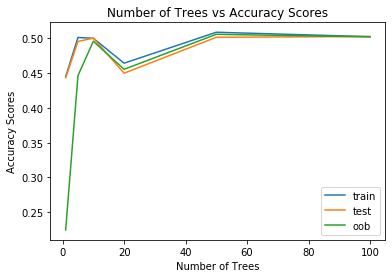

In [59]:
# Accuracy Plots
n_trees = [1, 5, 10, 20, 50, 100]
plt.plot(n_trees, train_acc, label='train')
plt.plot(n_trees, test_acc, label='test')
plt.plot(n_trees, oob_scores, label='oob')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy Scores')
plt.title('Number of Trees vs Accuracy Scores')
plt.legend(loc='lower right')
plt.show()

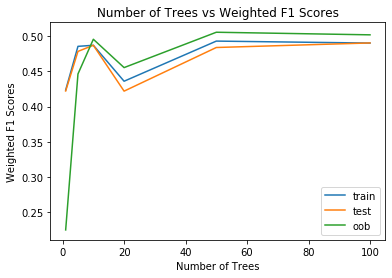

In [61]:
# F1-scores plots
plt.plot(n_trees, f1_train, label='train')
plt.plot(n_trees, f1_test, label='test')
plt.plot(n_trees, oob_scores, label='oob')
plt.xlabel('Number of Trees')
plt.ylabel('Weighted F1 Scores')
plt.title('Number of Trees vs Weighted F1 Scores')
plt.legend(loc='lower right')
plt.show()

In [62]:
best_params

[{'min_samples_leaf': 5000, 'max_features': 16},
 {'min_samples_leaf': 1000, 'max_features': 10},
 {'min_samples_leaf': 1000, 'max_features': 16},
 {'min_samples_leaf': 1000, 'max_features': 5},
 {'min_samples_leaf': 1000, 'max_features': 10},
 {'min_samples_leaf': 1000, 'max_features': 16}]

In [68]:
from sklearn.metrics import confusion_matrix, classification_report

In [69]:
# Training the best model according to the plots
rf = RandomForestClassifier(random_state=42,
                            n_jobs=4,
                            n_estimators=50,
                            min_samples_leaf=1000,
                            max_depth=10,
                            oob_score=True)
rf.fit(trans_xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1000, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
                       oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [72]:
# Training Classification Report
print(classification_report(ytrain, rf.predict(trans_xtrain)))

              precision    recall  f1-score   support

           0       0.47      0.80      0.59     75918
           1       0.79      0.97      0.87     90583
           2       0.40      0.34      0.37     86805
           3       0.73      0.04      0.08     45062
           4       0.31      0.38      0.34     70263
           5       0.33      0.46      0.39    124021
           6       0.32      0.08      0.13     76828
           7       0.34      0.35      0.34     50547
           8       0.58      0.63      0.60     66269
           9       0.39      0.27      0.32     97828

    accuracy                           0.45    784124
   macro avg       0.47      0.43      0.40    784124
weighted avg       0.46      0.45      0.42    784124



In [73]:
# Testing Classification Report
print(classification_report(ytest, rf.predict(trans_xtest)))

              precision    recall  f1-score   support

           0       0.46      0.79      0.58     19055
           1       0.79      0.97      0.87     22590
           2       0.40      0.30      0.35     21825
           3       0.74      0.02      0.05     11251
           4       0.30      0.37      0.33     17699
           5       0.33      0.46      0.38     31027
           6       0.31      0.09      0.14     19270
           7       0.34      0.36      0.35     12565
           8       0.58      0.60      0.59     16495
           9       0.37      0.28      0.32     24254

    accuracy                           0.45    196031
   macro avg       0.46      0.42      0.39    196031
weighted avg       0.45      0.45      0.41    196031



In [74]:
# Training the best model according to the plots with more depths (15)
rf = RandomForestClassifier(random_state=42,
                            n_jobs=4,
                            n_estimators=50,
                            min_samples_leaf=1000,
                            max_depth=15,
                            oob_score=True)
rf.fit(trans_xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1000, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
                       oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [76]:
print(f"Training Accuracy Score: {accuracy_score(ytrain, rf.predict(trans_xtrain))}")
print(f"Testing Accuracy Score: {accuracy_score(ytest, rf.predict(trans_xtest))}")

Training Accuracy Score: 0.4636715621508843
Testing Accuracy Score: 0.4559380914243155


In [77]:
print(classification_report(ytest, rf.predict(trans_xtest)))

              precision    recall  f1-score   support

           0       0.47      0.81      0.59     19055
           1       0.88      0.96      0.92     22590
           2       0.40      0.32      0.36     21825
           3       0.75      0.02      0.04     11251
           4       0.33      0.40      0.36     17699
           5       0.33      0.46      0.38     31027
           6       0.32      0.09      0.14     19270
           7       0.34      0.37      0.35     12565
           8       0.59      0.60      0.59     16495
           9       0.38      0.30      0.34     24254

    accuracy                           0.46    196031
   macro avg       0.48      0.43      0.41    196031
weighted avg       0.47      0.46      0.43    196031



In [78]:
# Training the best model according to the plots with more depths (15) and min_sample_leafs (500)
rf = RandomForestClassifier(random_state=42,
                            n_jobs=4,
                            n_estimators=50,
                            min_samples_leaf=500,
                            max_depth=15,
                            oob_score=True)
rf.fit(trans_xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=500, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
                       oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [80]:
print(f"Training Accuracy Score: {accuracy_score(ytrain, rf.predict(trans_xtrain))}")
print(f"Testing Accuracy Score: {accuracy_score(ytest, rf.predict(trans_xtest))}")
print(f"OOB Accuracy Score: {rf.oob_score_}")

Training Accuracy Score: 0.4849003473940346
Testing Accuracy Score: 0.4763481286123113
OOB Accuracy Score: 0.47935530604853316


In [81]:
# Training the best model according to the plots with more depths (15) and min_sample_leafs (500)
rf = RandomForestClassifier(random_state=42,
                            n_jobs=4,
                            n_estimators=50,
                            min_samples_leaf=100,
                            max_depth=15,
                            oob_score=True)
rf.fit(trans_xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
                       oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [82]:
print(f"Training Accuracy Score: {accuracy_score(ytrain, rf.predict(trans_xtrain))}")
print(f"Testing Accuracy Score: {accuracy_score(ytest, rf.predict(trans_xtest))}")
print(f"OOB Accuracy Score: {rf.oob_score_}")

Training Accuracy Score: 0.5256400773347073
Testing Accuracy Score: 0.5111895567537788
OOB Accuracy Score: 0.5140934342017334


In [83]:
# Testing Classification Report
print(classification_report(ytest, rf.predict(trans_xtest)))

              precision    recall  f1-score   support

           0       0.55      0.83      0.66     19055
           1       0.97      0.98      0.98     22590
           2       0.44      0.40      0.42     21825
           3       0.65      0.16      0.26     11251
           4       0.40      0.52      0.45     17699
           5       0.38      0.47      0.42     31027
           6       0.37      0.16      0.22     19270
           7       0.38      0.38      0.38     12565
           8       0.61      0.67      0.64     16495
           9       0.43      0.38      0.41     24254

    accuracy                           0.51    196031
   macro avg       0.52      0.49      0.48    196031
weighted avg       0.51      0.51      0.49    196031

